In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=30


x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)

A=mk_laplace_2d(dim,dim)
AType='2D Laplacian'

retrain_freq=1
e1 = 1e-5
e2 = 1e-6
nmax_iter =int(dim/5)
restart   = 64

# sigma=0.02
sigma=0.2


DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =2000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# check 2d grid and RHS

import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = pp.figure()
ax = fig.add_subplot(111, projection='3d')
ProbIdx=50

# Z=np.sin(1)*X+np.cos(1)*Y

xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
Z=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

# Z=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

ax.plot_surface(X,Y,Z,cmap=cm.coolwarm)

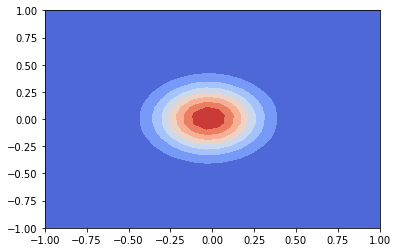

In [5]:
pp.contourf(X,Y,Z,cmap=cm.coolwarm)

In [6]:
# Initial log message
logger.info("Test 2D problem using 2 2DConv (1 channel. Kernels  are 9x9,7x7) + 1 FC . Dim 30. Wide source (sig-0.2). e1=10^{-5}. 'Standard network parameters'. 1000 Epochs and  32 batches ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-07-04 12:39:49 [INFO] <ipython-input-6-7eaf72ce4899> 2 - Test 2D problem using 2 2DConv (1 channel. Kernels  are 9x9,7x7) + 1 FC . Dim 30. Wide source (sig-0.2). e1=10^{-5}. 'Standard network parameters'. 1000 Epochs and  32 batches 


In [7]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed_2D(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b ,x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [8]:
from src_dir import *



ML_GMRES_Time_list=[]
ML_GMRES_Time_list2=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]
reslist_flat=[]


for ProbIdx in range(n_steps):


    xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
    yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
    b=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)


#     b=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

    b_flat=np.reshape(b,(1,-1),order='F').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]
    reslist_flat=OutList1[6]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    reslist_flat=OutList2[6]
    ML_GMRES_Time_list2=OutList2[7]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[5])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list2)+sum(ML_GMRES_Time_list)

    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)

logger.info("Runtime of MLGMRES (only GMRES time) is:")
logger.info(MLGMRES_GMRES_ONLY)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 7.5283742262399755e-06
parameters 811294
Initial Training
2
size 8
0.5975437238979946 0.5512335420062466
poor prediction,using initial x0
1.9042799430026207 1.882174369005952 0.5975437238979946 0.5369706928559461
1.9042799430026207 1.882174369005952 0.5975437238979946 0.5369706928559461
3
size 8
0.5244414935015852 0.5975437238979946
2.123304292996181 1.8885670815070625 1.9527176637126586 0.5743886329521206
2.123304292996181 1.8885670815070625 1.9527176637126586 0.5743886329521206
4
size 8
0.5558806037402523 1.9527176637126586
2.0854786060081096 1.9668128186701022 1.949885689653946 1.0338316432056331
2.0854786060081096 1.9668128186701022 1.949885689653946 1.0338316432056331
InnerProd [[1.         0.82446373 0.74981105]
 [0.82446373 1.         0.91833151]
 [0.74981105 0.91833151 1.        ]]
retraining
2
Final loss: 1.4070938959775958e-05
parameters 811294
5
size 8
0.5532929744327327 1.9527176637126586
1.7496555519901449 2.0376876140023037 1.928419731270478 1.500049025754

1.5891619299945887 1.7457729923195437 0.4280544822658427 1.1339254861309433
1.5891619299945887 1.7457729923195437 0.4280544822658427 1.1339254861309433
40
size 8
0.5920507544504922 2.4182928441878615
2.0919464259932283 1.7196289245598018 0.4788133667775655 1.0811681800157573
2.0919464259932283 1.7196289245598018 0.4788133667775655 1.0811681800157573
41
size 8
0.5398373430018224 2.4182928441878615
2.0313305660092738 1.7428112013597274 1.5119617419584277 1.0180279203920828
2.0313305660092738 1.7428112013597274 1.5119617419584277 1.0180279203920828
42
size 8
0.5094351539711593 2.4182928441878615
1.5888602129998617 1.7619293488399126 1.0978171780303092 1.0161596338310495
1.5888602129998617 1.7619293488399126 1.0978171780303092 1.0161596338310495
43
size 8
0.5078111053590437 2.4182928441878615
0.9180170130130136 1.7494036477594637 0.04628777790762141 0.9944298995940005
0.9180170130130136 1.7494036477594637 0.04628777790762141 0.9944298995940005
44
size 8
0.5281302799581101 2.418292844187861

1.1003145200083964 1.619213940319605 0.035607575998522024 0.5242714584991355
78
size 8
0.5644376834467448 2.4182928441878615
1.8267165580036817 1.5613822482799877 1.0382851625568592 0.5083746487184443
1.8267165580036817 1.5613822482799877 1.0382851625568592 0.5083746487184443
79
size 8
0.5548616156804222 2.4182928441878615
1.282404432000476 1.587874923920026 0.37771449074264984 0.5055328721387936
1.282404432000476 1.587874923920026 0.37771449074264984 0.5055328721387936
80
size 8
0.5516962060200804 2.4182928441878615
0.6963882239942905 1.5841169893200275 0.49253639283590467 0.49220631560168576
0.6963882239942905 1.5841169893200275 0.49253639283590467 0.49220631560168576
81
size 8
0.5013104348937999 2.4182928441878615
1.9924167550052516 1.5823869409196778 0.4162343182986028 0.4600647212456211
1.9924167550052516 1.5823869409196778 0.4162343182986028 0.4600647212456211
82
size 8
0.5468219410365078 2.4182928441878615
1.041045177000342 1.595528212119825 0.12222400452856323 0.471042345621054

1.0667910449992632 1.4331364484410734 0.13576199263137587 0.26433256119962795
117
size 8
0.7401503781825646 2.4182928441878615
1.435616356000537 1.4137029746809275 0.3850014053503225 0.258044186198586
1.435616356000537 1.4137029746809275 0.3850014053503225 0.258044186198586
118
size 8
0.6339109155981557 2.4182928441878615
1.1894246399897384 1.4173529210407287 0.15126608918304107 0.2615604716304352
1.1894246399897384 1.4173529210407287 0.15126608918304107 0.2615604716304352
119
size 8
0.5205321899803527 2.4182928441878615
1.9130547149979975 1.4279407415603054 0.29981918510207667 0.26663402069887665
1.9130547149979975 1.4279407415603054 0.29981918510207667 0.26663402069887665
120
size 8
0.5269908502082628 2.4182928441878615
1.6106238180072978 1.429697116840398 0.49382237429095494 0.26901362081639857
1.6106238180072978 1.429697116840398 0.49382237429095494 0.26901362081639857
InnerProd [[1.         0.54662524 0.4893966 ]
 [0.54662524 1.         0.63388936]
 [0.4893966  0.63388936 1.      

1.3528871579910628 1.3572446687606863 0.06904235107768507 0.17523363849338236
155
size 8
0.552926038740148 2.4182928441878615
1.02729908299807 1.3523168054403505 0.13877221893092298 0.17134355320158282
1.02729908299807 1.3523168054403505 0.13877221893092298 0.17134355320158282
156
size 8
0.5553281767188515 2.4182928441878615
1.4565385159949074 1.3394941251602723 0.1198571590023841 0.16854172768947087
1.4565385159949074 1.3394941251602723 0.1198571590023841 0.16854172768947087
157
size 8
0.5852858573973395 2.4182928441878615
1.2838531990128104 1.3274840764398688 0.061070983316418026 0.16954005969458832
1.2838531990128104 1.3274840764398688 0.061070983316418026 0.16954005969458832
158
size 8
0.5260064350611465 2.4182928441878615
1.4298614589934004 1.3418344231205992 0.14453551574114598 0.1690075239627138
1.4298614589934004 1.3418344231205992 0.14453551574114598 0.1690075239627138
159
size 8
0.505263190396189 2.4182928441878615
1.4214253020036267 1.3303536252002233 0.370018658894472 0.163

1.4977695840061642 1.3138875525991898 0.07911167580649285 0.1469238562653594
194
size 8
0.5055000182054721 2.4182928441878615
0.9727502260066103 1.3312472496397094 0.05708905293081009 0.1452037921710845
0.9727502260066103 1.3312472496397094 0.05708905293081009 0.1452037921710845
195
size 8
0.5262380474862619 2.4182928441878615
1.4608402239973657 1.2763389299198753 0.20220486913596084 0.1346296592822948
1.4608402239973657 1.2763389299198753 0.20220486913596084 0.1346296592822948
InnerProd [[1.         0.48335963 0.83844051]
 [0.48335963 1.         0.56436643]
 [0.83844051 0.56436643 1.        ]]
retraining
2
Final loss: 1.0113290548324585
parameters 811294
196
size 8
0.5851431585631587 2.4182928441878615
0.6842189390008571 1.2751425321999705 0.11180955249898221 0.13401352495795554
0.6842189390008571 1.2751425321999705 0.11180955249898221 0.13401352495795554
197
size 8
0.5553525700649702 2.4182928441878615
1.4137242249998963 1.2331317869597114 0.08623362286084268 0.1355298362943132
1.413

1.623042577994056 1.1749089011189062 0.11874142635842151 0.11510295911440631
231
size 8
0.5589836535991061 2.4182928441878615
0.8016028050042223 1.2068911557586397 0.02460347294846828 0.11817645063170794
0.8016028050042223 1.2068911557586397 0.02460347294846828 0.11817645063170794
232
size 8
0.5380229608985411 2.4182928441878615
1.2775143019971438 1.1763805500388844 0.30061895918334847 0.1116372005400914
1.2775143019971438 1.1763805500388844 0.30061895918334847 0.1116372005400914
233
size 8
0.5269651174013892 2.4182928441878615
1.0813790860120207 1.1816544872388477 0.09081438142436071 0.11884080757993179
1.0813790860120207 1.1816544872388477 0.09081438142436071 0.11884080757993179
234
size 8
0.5204220702530484 2.4182928441878615
1.1059195770067163 1.1578457714390242 0.07972367864169566 0.12019699608564835
1.1059195770067163 1.1578457714390242 0.07972367864169566 0.12019699608564835
235
size 8
0.6339398143577745 2.4182928441878615
1.0975659559771884 1.1535142777592409 0.1823436716332660

1.1178189039928839 1.1366709383984561 0.11834790121064899 0.08903440942578335
1.1178189039928839 1.1366709383984561 0.11834790121064899 0.08903440942578335
269
size 8
0.5145854127757508 2.4182928441878615
0.5903635750000831 1.154505887759151 0.10746220926069099 0.09166438441687222
0.5903635750000831 1.154505887759151 0.10746220926069099 0.09166438441687222
270
size 8
0.5658957976184178 2.4182928441878615
1.1255851090245415 1.1500225771591068 0.07552628725596248 0.09410602917347928
1.1255851090245415 1.1500225771591068 0.07552628725596248 0.09410602917347928
271
size 8
0.5468117953849487 2.4182928441878615
0.754750876018079 1.1469669527595396 0.06259652138070064 0.09415033409222337
0.754750876018079 1.1469669527595396 0.06259652138070064 0.09415033409222337
272
size 8
0.500992817139135 2.4182928441878615
0.7925392460019793 1.1304849392804317 0.02666391424319421 0.09523666191584171
0.7925392460019793 1.1304849392804317 0.02666391424319421 0.09523666191584171
273
size 8
0.5521318999916435

Final loss: 0.6739856004714966
parameters 811294
307
size 8
0.5356345160911151 2.4182928441878615
0.7054238219861872 1.0410202284820844 0.06399865374480643 0.06965319136755364
0.7054238219861872 1.0410202284820844 0.06399865374480643 0.06965319136755364
308
size 8
0.5640522622423775 2.4182928441878615
0.687795562989777 1.0424639959214255 0.08869853496718359 0.07060556621695468
0.687795562989777 1.0424639959214255 0.08869853496718359 0.07060556621695468
309
size 8
0.5281229323321437 2.4182928441878615
1.0891453890071716 1.0345331132411957 0.07728613049915953 0.07203036898659808
1.0891453890071716 1.0345331132411957 0.07728613049915953 0.07203036898659808
310
size 8
0.5078006600425006 2.4182928441878615
1.3499346179887652 1.0386406644410453 0.040011259777524344 0.07022369655590399
1.3499346179887652 1.0386406644410453 0.040011259777524344 0.07022369655590399
311
size 8
0.5094675969090094 2.4182928441878615
0.7715516320022289 1.0382884418405594 0.05170879184422088 0.06793704303949645
0.77

0.8504389330046251 0.9402483946376015 0.012771553017022406 0.054683129573334384
0.8504389330046251 0.9402483946376015 0.012771553017022406 0.054683129573334384
346
size 8
0.6191429129211269 2.4182928441878615
1.017436149995774 0.9320170435984619 0.039732865137146536 0.05414893303706134
1.017436149995774 0.9320170435984619 0.039732865137146536 0.05414893303706134
347
size 8
0.484097085945448 2.4182928441878615
0.9435157919942867 0.933183376158122 0.025430326329097076 0.054138128842717556
0.9435157919942867 0.933183376158122 0.025430326329097076 0.054138128842717556
348
size 8
0.5533134131355208 2.4182928441878615
0.757185181020759 0.9222930123982951 0.04706810141792992 0.053847971782468924
0.757185181020759 0.9222930123982951 0.04706810141792992 0.053847971782468924
349
size 8
0.5558684191530324 2.4182928441878615
0.7258714809722733 0.918192986799404 0.12138951565607216 0.053476750389526234
0.7258714809722733 0.918192986799404 0.12138951565607216 0.053476750389526234
350
size 8
0.524068

0.8335051460016984 1.0122739816398825 0.08029580627054077 0.05390474096616771
383
size 8
0.47289774851294575 2.4182928441878615
1.2772159529849887 1.0019934729195665 0.06352463013964095 0.0541066383582479
1.2772159529849887 1.0019934729195665 0.06352463013964095 0.0541066383582479
384
size 8
0.6191647488378275 2.4182928441878615
1.146947135013761 1.010011786238756 0.0476942813439327 0.05428992964198411
1.146947135013761 1.010011786238756 0.0476942813439327 0.05428992964198411
385
size 8
0.5385100827091645 2.4182928441878615
0.7334208890097216 1.0203218257194384 0.044664051953361664 0.05503911862681782
0.7334208890097216 1.0203218257194384 0.044664051953361664 0.05503911862681782
386
size 8
0.5138506064006805 2.4182928441878615
0.8073599399940576 1.0184847301605624 0.09035610797280136 0.055784224153313765
0.8073599399940576 1.0184847301605624 0.09035610797280136 0.055784224153313765
387
size 8
0.5064725445206475 2.4182928441878615
1.0344996050116606 0.9973408127203583 0.0589656186967002

Final loss: 0.6768301725387573
parameters 811294
420
size 8
0.5116337049031658 2.4182928441878615
0.6769680280121975 0.989897329241503 0.028549024490761972 0.043944792768169295
0.6769680280121975 0.989897329241503 0.028549024490761972 0.043944792768169295
421
size 8
0.5303732391038568 2.4182928441878615
1.1179980419983622 0.9637287981214467 0.03845788550239252 0.043714809921457466
1.1179980419983622 0.9637287981214467 0.03845788550239252 0.043714809921457466
422
size 8
0.5649175781851807 2.4182928441878615
1.2508284930081572 0.9874672891222872 0.02915051063263493 0.044493581743883445
1.2508284930081572 0.9874672891222872 0.02915051063263493 0.044493581743883445
423
size 8
0.5477145548756962 2.4182928441878615
1.2671977510035504 0.9867840934032575 0.054691522875271396 0.043194354463318894
1.2671977510035504 0.9867840934032575 0.054691522875271396 0.043194354463318894
424
size 8
0.630922531136988 2.4182928441878615
0.92041426099604 1.0039288461627438 0.06960062713318098 0.044883062696096

458
size 8
0.6623812655727943 2.4182928441878615
1.036573810997652 0.8669697820802685 0.06110699791552944 0.03303979308655764
1.036573810997652 0.8669697820802685 0.06110699791552944 0.03303979308655764
InnerProd [[1.         0.78905418 0.82999155]
 [0.78905418 1.         0.60464924]
 [0.82999155 0.60464924 1.        ]]
retraining
2
Final loss: 0.5210584402084351
parameters 811294
459
size 8
0.5513287996424101 2.4182928441878615
1.4308163780078758 0.8820945615193341 0.07339611477915566 0.034751432865269105
1.4308163780078758 0.8820945615193341 0.07339611477915566 0.034751432865269105
460
size 8
0.5602277859452428 2.4182928441878615
1.0707041989953723 0.9087933535990306 0.029190698261384772 0.0371915654991081
1.0707041989953723 0.9087933535990306 0.029190698261384772 0.0371915654991081
461
size 8
0.6542798043908418 2.4182928441878615
1.0763291280018166 0.9135104615194723 0.050225454889361844 0.03691891656985732
1.0763291280018166 0.9135104615194723 0.050225454889361844 0.036918916569857

0.8473811400181148 0.9295313267991878 0.0352468473088795 0.03889248504519191
494
size 8
0.6432628925306348 2.4182928441878615
1.2411291759926826 0.932681880480377 0.02225247048252273 0.0394496862723753
1.2411291759926826 0.932681880480377 0.02225247048252273 0.0394496862723753
495
size 8
0.5976126294147323 2.4182928441878615
0.9504181929805782 0.936199375439901 0.045397241694997065 0.03803432409800667
0.9504181929805782 0.936199375439901 0.045397241694997065 0.03803432409800667
496
size 8
0.559953406945748 2.4182928441878615
0.909723244025372 0.9415535215998534 0.01672042043005341 0.03823139212704782
0.909723244025372 0.9415535215998534 0.01672042043005341 0.03823139212704782
497
size 8
0.5349663199236637 2.4182928441878615
0.8091639509948436 0.941991056239931 0.016491995357480606 0.03675668546110681
0.8091639509948436 0.941991056239931 0.016491995357480606 0.03675668546110681
498
size 8
0.5420515700761321 2.4182928441878615
0.9841607180132996 0.9280594553204718 0.028751209270111187 0.

531
size 8
0.548577312595023 2.4182928441878615
0.9456925200065598 1.1074975207576063 0.023361093674414708 0.03533523350594332
0.9456925200065598 1.1074975207576063 0.023361093674414708 0.03533523350594332
532
size 8
0.5485321281209202 2.4182928441878615
0.941024400992319 1.1059756023576484 0.025203479177467035 0.03381435795232337
0.941024400992319 1.1059756023576484 0.025203479177467035 0.03381435795232337
533
size 8
0.5474842492674343 2.4182928441878615
0.8625805669871625 1.106189433397958 0.03556277991182207 0.03290074556810415
0.8625805669871625 1.106189433397958 0.03556277991182207 0.03290074556810415
534
size 8
0.6045049209754798 2.4182928441878615
1.0243134180200286 1.0825006673578172 0.050403979265397275 0.032608285444071815
1.0243134180200286 1.0825006673578172 0.050403979265397275 0.032608285444071815
535
size 8
0.5138644260554018 2.4182928441878615
1.1830655869853217 1.0606296765187289 0.0171137671418015 0.03338905814455528
1.1830655869853217 1.0606296765187289 0.01711376714

0.8736283460166305 0.9868478063575458 0.036679834500499935 0.03161908718422444
0.8736283460166305 0.9868478063575458 0.036679834500499935 0.03161908718422444
569
size 8
0.645413499493472 2.4182928441878615
1.0970751759887207 0.9896037052781321 0.026032744084787396 0.03185467775517728
1.0970751759887207 0.9896037052781321 0.026032744084787396 0.03185467775517728
570
size 8
0.5494576501502335 2.4182928441878615
0.9856235159968492 0.9837637355574407 0.022481088892128978 0.03089011793055644
0.9856235159968492 0.9837637355574407 0.022481088892128978 0.03089011793055644
571
size 8
0.5525796645367682 2.4182928441878615
0.8711161349783652 0.9673691183177289 0.025905402228650648 0.03051538781557756
0.8711161349783652 0.9673691183177289 0.025905402228650648 0.03051538781557756
572
size 8
0.6711564256636918 2.4182928441878615
1.03632414599997 0.9659740487567615 0.02586769390256158 0.030264684036071597
1.03632414599997 0.9659740487567615 0.02586769390256158 0.030264684036071597
573
size 8
0.531793

0.9893333889776841 0.9300157419184688 0.04418365511164694 0.0288752401547358
0.9893333889776841 0.9300157419184688 0.04418365511164694 0.0288752401547358
607
size 8
0.5629207003861963 2.4182928441878615
0.9817879350157455 0.9107300925580785 0.03320972345772413 0.029703997419547615
0.9817879350157455 0.9107300925580785 0.03320972345772413 0.029703997419547615
608
size 8
0.5622687714958471 2.4182928441878615
1.0139293269894551 0.9322886623593513 0.024480789544863053 0.030295415465922227
1.0139293269894551 0.9322886623593513 0.024480789544863053 0.030295415465922227
609
size 8
0.5345102043648727 2.4182928441878615
0.5497322500159498 0.921496978799114 0.011834616648611577 0.03023440034249851
0.5497322500159498 0.921496978799114 0.011834616648611577 0.03023440034249851
610
size 8
0.5198933706351021 2.4182928441878615
0.7994085810205434 0.9013871461199596 0.020384583051197 0.029045627638694286
0.7994085810205434 0.9013871461199596 0.020384583051197 0.029045627638694286
611
size 8
0.498471122

1.0426263959961943 0.9151759405981283 0.026460267786193935 0.02403486765933299
644
size 8
0.4997655889513461 2.4182928441878615
0.8560153429862112 0.9180725061579141 0.06995984100787582 0.024412131322659323
0.8560153429862112 0.9180725061579141 0.06995984100787582 0.024412131322659323
645
size 8
0.5592400280498345 2.4182928441878615
0.895065345976036 0.9255494241183624 0.020988558763650966 0.026751150341881358
0.895065345976036 0.9255494241183624 0.020988558763650966 0.026751150341881358
646
size 8
0.5242848439046478 2.4182928441878615
0.7237398999859579 0.9263958112383262 0.04155515982312607 0.026756468099348316
0.7237398999859579 0.9263958112383262 0.04155515982312607 0.026756468099348316
647
size 8
0.5476226755505491 2.4182928441878615
1.249401648005005 0.9022097491973545 0.027083886018065124 0.02747930354086658
1.249401648005005 0.9022097491973545 0.027083886018065124 0.02747930354086658
648
size 8
0.545264657742808 2.4182928441878615
0.6634807289810851 0.9098898416780866 0.0214335

0.7285701330110896 0.8994955654407386 0.014015045104254567 0.02111872073494674
683
size 8
0.6797582114841066 2.4182928441878615
0.9756101330276579 0.9035232699208428 0.016796168068933193 0.020928942435353228
0.9756101330276579 0.9035232699208428 0.016796168068933193 0.020928942435353228
684
size 8
0.5512258963106705 2.4182928441878615
0.8967427040042821 0.9079056144016795 0.014721263084262066 0.02053096226760939
0.8967427040042821 0.9079056144016795 0.014721263084262066 0.02053096226760939
685
size 8
0.5597124121127286 2.4182928441878615
0.8022990729950834 0.9038224598811939 0.024750480213581207 0.02034545079175089
0.8022990729950834 0.9038224598811939 0.024750480213581207 0.02034545079175089
686
size 8
0.525828881069254 2.4182928441878615
0.7382081160030793 0.9081558686005883 0.013365009549240206 0.020526999417947316
0.7382081160030793 0.9081558686005883 0.013365009549240206 0.020526999417947316
687
size 8
0.5054882410836302 2.4182928441878615
0.9985051969997585 0.9045482698804699 0.0

0.8489304170070682 0.9185496335208881 0.016671212506623907 0.021888304652291544
721
size 8
0.5244706368567528 2.4182928441878615
0.8901721730071586 0.8998557995609008 0.029151377872384844 0.021049782993557916
0.8901721730071586 0.8998557995609008 0.029151377872384844 0.021049782993557916
722
size 8
0.5560528034805964 2.4182928441878615
0.8384068479936104 0.9079034273209982 0.010329184534053933 0.0205228858460405
0.8384068479936104 0.9079034273209982 0.010329184534053933 0.0205228858460405
723
size 8
0.5719051511444189 2.4182928441878615
0.8483025160094257 0.9046889553207439 0.012869718938118536 0.020040252761824445
0.8483025160094257 0.9046889553207439 0.012869718938118536 0.020040252761824445
724
size 8
0.5945135622305857 2.4182928441878615
0.790843174996553 0.8884781964414288 0.01755363178849721 0.019867874936678968
0.790843174996553 0.8884781964414288 0.01755363178849721 0.019867874936678968
725
size 8
0.5555527407482034 2.4182928441878615
1.2705429710040335 0.9017416050005704 0.021

0.6751702559995465 1.0243737016385421 0.011354871918173451 0.020018465898724632
757
size 8
0.7756522019628068 2.4182928441878615
0.9802840579941403 1.0302827359980438 0.027983484341667565 0.01999431368928485
0.9802840579941403 1.0302827359980438 0.027983484341667565 0.01999431368928485
758
size 8
0.49089463757308116 2.4182928441878615
1.1685301859979518 1.0312725461181254 0.016666286264346113 0.02024552066892468
1.1685301859979518 1.0312725461181254 0.016666286264346113 0.02024552066892468
759
size 8
0.5454729367135925 2.4182928441878615
0.9837067080079578 1.0384831212775316 0.01610832038022356 0.020293259331570352
0.9837067080079578 1.0384831212775316 0.01610832038022356 0.020293259331570352
760
size 8
0.5227106265300154 2.4182928441878615
0.6110322969907429 1.035397020158125 0.015826393885155783 0.02038309925560176
0.6110322969907429 1.035397020158125 0.015826393885155783 0.02038309925560176
761
size 8
0.5554542706209081 2.4182928441878615
0.7284199619898573 1.0148283347580582 0.0206

0.7519468439859338 0.7786914945184253 0.022891071048912418 0.01680317281848476
795
size 8
0.598491370023897 2.4182928441878615
0.6618026960059069 0.7831080552376807 0.013835018399614775 0.017109161697537494
0.6618026960059069 0.7831080552376807 0.013835018399614775 0.017109161697537494
796
size 8
0.49532997882024 2.4182928441878615
0.7672128359845374 0.7767489521985408 0.01225911306616998 0.016965628875127346
0.7672128359845374 0.7767489521985408 0.01225911306616998 0.016965628875127346
797
size 8
0.5168784721208797 2.4182928441878615
1.0841411699948367 0.776542515117908 0.015248655962222238 0.01680618440066833
1.0841411699948367 0.776542515117908 0.015248655962222238 0.01680618440066833
798
size 8
0.533020323232581 2.4182928441878615
0.9754810660087969 0.7902911766781472 0.020450266790972005 0.016462387309266552
0.9754810660087969 0.7902911766781472 0.020450266790972005 0.016462387309266552
799
size 8
0.5635007562293369 2.4182928441878615
0.4440668099850882 0.8067509677587077 0.017354

0.868955496000126 0.8509064070403111 0.01525227308062809 0.018654808495396878
832
size 8
0.5589462285353032 2.4182928441878615
0.834656327002449 0.8534224521601572 0.021254215145749503 0.018641566767650917
0.834656327002449 0.8534224521601572 0.021254215145749503 0.018641566767650917
833
size 8
0.563188318373142 2.4182928441878615
1.1184066989808343 0.846149049079977 0.01497404510144548 0.01801917298366472
1.1184066989808343 0.846149049079977 0.01497404510144548 0.01801917298366472
834
size 8
0.5070164480489298 2.4182928441878615
0.4865819360129535 0.8686832737189252 0.012393717991576883 0.018192233072922212
0.4865819360129535 0.8686832737189252 0.012393717991576883 0.018192233072922212
835
size 8
0.7460769600299931 2.4182928441878615
0.9419491509906948 0.839281600038521 0.027108325548383633 0.01751189852560845
0.9419491509906948 0.839281600038521 0.027108325548383633 0.01751189852560845
836
size 8
0.5559339979125059 2.4182928441878615
1.2035820510063786 0.8545747071981896 0.0094176203

0.726638765016105 0.8136267632828094 0.012245650982001527 0.016979939288583153
870
size 8
0.5459703754397183 2.4182928441878615
0.5934551700192969 0.8020182611234487 0.013998374959210007 0.016457660402533575
0.5934551700192969 0.8020182611234487 0.013998374959210007 0.016457660402533575
871
size 8
0.4880054298976013 2.4182928441878615
1.1373420230229385 0.7897241210041102 0.016007094977686737 0.01648801623445063
1.1373420230229385 0.7897241210041102 0.016007094977686737 0.01648801623445063
872
size 8
0.5348460382737568 2.4182928441878615
0.702884541999083 0.7952751236455515 0.01710555620739425 0.016597293407325978
0.702884541999083 0.7952751236455515 0.01710555620739425 0.016597293407325978
873
size 8
0.5969162995064565 2.4182928441878615
0.8306878430012148 0.8078186402050779 0.008499739119162698 0.016490710781759337
0.8306878430012148 0.8078186402050779 0.008499739119162698 0.016490710781759337
874
size 8
0.5434079672346862 2.4182928441878615
0.5184818730049301 0.8019648588856216 0.01

0.9991076909936965 0.9499921156815253 0.01639052726532959 0.018030850809068896
907
size 8
0.5554012966303826 2.4182928441878615
0.9488997680018656 0.9510267053614371 0.019798538012907173 0.018116994880046765
0.9488997680018656 0.9510267053614371 0.019798538012907173 0.018116994880046765
908
size 8
0.5529699399442214 2.4182928441878615
0.8492803819826804 0.9541369990818203 0.026640141918166056 0.01803035712677773
0.8492803819826804 0.9541369990818203 0.026640141918166056 0.01803035712677773
909
size 8
0.5441253067441859 2.4182928441878615
1.1045818259881344 0.9684146146802232 0.012241699478529655 0.018511122782797828
1.1045818259881344 0.9684146146802232 0.012241699478529655 0.018511122782797828
910
size 8
0.5390342097920632 2.4182928441878615
0.8257829750073142 0.9972660780791194 0.024946505790434625 0.018608136633860087
0.8257829750073142 0.9972660780791194 0.024946505790434625 0.018608136633860087
911
size 8
0.5800591888345338 2.4182928441878615
0.7579998660075944 0.9757047438388691 

0.8044123420258984 0.7628385516768321 0.012965033802903885 0.017024075975323488
945
size 8
0.6339956092792598 2.4182928441878615
0.8687952419859357 0.7618459316377993 0.029844976349195775 0.016966559173443214
0.8687952419859357 0.7618459316377993 0.029844976349195775 0.016966559173443214
946
size 8
0.7391098852560541 2.4182928441878615
0.6819179710000753 0.768182243356714 0.02179120056042109 0.01724422550476666
0.6819179710000753 0.768182243356714 0.02179120056042109 0.01724422550476666
947
size 8
0.5561271487675169 2.4182928441878615
0.9379553329781629 0.770390153157059 0.015152928840844928 0.01722229990978052
0.9379553329781629 0.770390153157059 0.015152928840844928 0.01722229990978052
948
size 8
0.5541654822558983 2.4182928441878615
0.9768608039885294 0.7896525674767326 0.017467505480334905 0.017442159533832217
0.9768608039885294 0.7896525674767326 0.017467505480334905 0.017442159533832217
949
size 8
0.7412111749133802 2.4182928441878615
0.7932220429938752 0.8010312929167412 0.01311

0.7150525210017804 0.7666416292788927 0.012499640493872415 0.016342421364666775
983
size 8
0.5530082263438862 2.4182928441878615
0.9564556510013063 0.7702898037584964 0.019373754023666374 0.016480284346075545
0.9564556510013063 0.7702898037584964 0.019373754023666374 0.016480284346075545
InnerProd [[1.         0.89755107 0.65953773]
 [0.89755107 1.         0.86363273]
 [0.65953773 0.86363273 1.        ]]
retraining
2
Final loss: 0.10859659314155579
parameters 811294
984
size 8
0.5547319349168764 2.4182928441878615
0.6809617470134981 0.7822484937985428 0.014163930988765597 0.01673928754063037
0.6809617470134981 0.7822484937985428 0.014163930988765597 0.01673928754063037
985
size 8
0.5644522924385633 2.4182928441878615
0.8088858730043285 0.7780015045194887 0.025480782641986523 0.016682697353745182
0.8088858730043285 0.7780015045194887 0.025480782641986523 0.016682697353745182
986
size 8
0.5315894089145695 2.4182928441878615
0.650210210995283 0.7841544075193815 0.006007446791145901 0.0166

1.0088352750171907 0.729340530000627 0.015493997470994123 0.015621640371868497
1021
size 8
0.5095324082235607 2.4182928441878615
0.9603293089894578 0.7425839466811158 0.03060113735790549 0.015739633466556078
0.9603293089894578 0.7425839466811158 0.03060113735790549 0.015739633466556078
1022
size 8
0.5397593385600274 2.4182928441878615
0.7350094860012177 0.7551410982408561 0.011190817526382265 0.01663634264871084
0.7350094860012177 0.7551410982408561 0.011190817526382265 0.01663634264871084
1023
size 8
0.5927383017937283 2.4182928441878615
0.8445475969929248 0.7585677732003387 0.016948860182220287 0.016379322270974904
0.8445475969929248 0.7585677732003387 0.016948860182220287 0.016379322270974904
InnerProd [[1.         0.58348657 0.90677748]
 [0.58348657 1.         0.45484482]
 [0.90677748 0.45484482 1.        ]]
retraining
2
Final loss: 0.11564847081899643
parameters 811294
1024
size 8
0.492529828636762 2.4182928441878615
0.78085132400156 0.7560764879197813 0.020657867823736457 0.01641

0.739756156981457 0.7125207534374204 0.011797705790133227 0.014337694817168725
1058
size 8
0.553354258727103 2.4182928441878615
0.708865889988374 0.7224326306767762 0.011417764128245057 0.014320786568774342
0.708865889988374 0.7224326306767762 0.011417764128245057 0.014320786568774342
1059
size 8
0.5558436918102408 2.4182928441878615
0.47743942102533765 0.7337629732361529 0.009859038392011667 0.014104040788171015
0.47743942102533765 0.7337629732361529 0.009859038392011667 0.014104040788171015
1060
size 8
0.5233261584212954 2.4182928441878615
0.7708306119893678 0.7293423757574056 0.011067743975272715 0.01400012917526712
0.7708306119893678 0.7293423757574056 0.011067743975272715 0.01400012917526712
1061
size 8
0.5980531908239156 2.4182928441878615
1.0801272820099257 0.7418268747569527 0.010428411811333985 0.013517658785238204
1.0801272820099257 0.7418268747569527 0.010428411811333985 0.013517658785238204
1062
size 8
0.5511283281709474 2.4182928441878615
0.5883011700061616 0.7517952104366

0.7558353919885121 0.8046988957584835 0.017782555650922835 0.01294165525583168
1095
size 8
0.5384975942358315 2.4182928441878615
1.3142210179939866 0.7934425680781715 0.012617673176917874 0.013146692569345801
1.3142210179939866 0.7934425680781715 0.012617673176917874 0.013146692569345801
1096
size 8
0.5137948826883576 2.4182928441878615
0.6906838189752307 0.8100402695988305 0.016370247527692654 0.01322066251767954
0.6906838189752307 0.8100402695988305 0.016370247527692654 0.01322066251767954
1097
size 8
0.506488376765086 2.4182928441878615
0.7317980850057211 0.7988108156376984 0.008489438868121094 0.01352373038801869
0.7317980850057211 0.7988108156376984 0.008489438868121094 0.01352373038801869
1098
size 8
0.5270585013967609 2.4182928441878615
1.0030086540209595 0.7841702422779053 0.02176411892254292 0.012822622696895637
1.0030086540209595 0.7841702422779053 0.02176411892254292 0.012822622696895637
1099
size 8
0.5624597847154259 2.4182928441878615
0.7535974390048068 0.7944922607589979 

0.7776687660079915 0.9178997693990822 0.015220193820307091 0.011433250252300044
0.7776687660079915 0.9178997693990822 0.015220193820307091 0.011433250252300044
1133
size 8
0.547820874862349 2.4182928441878615
0.9276542940060608 0.915878774599405 0.010960461610215607 0.011764137500793925
0.9276542940060608 0.915878774599405 0.010960461610215607 0.011764137500793925
1134
size 8
0.6296652784013437 2.4182928441878615
1.3624447770125698 0.915021513159154 0.020676501933655906 0.011759630476493888
1.3624447770125698 0.915021513159154 0.020676501933655906 0.011759630476493888
InnerProd [[1.         0.53752108 0.91717108]
 [0.53752108 1.         0.45761561]
 [0.91717108 0.45761561 1.        ]]
retraining
2
Final loss: 0.10603836923837662
parameters 811294
1135
size 8
0.4718620188592994 2.4182928441878615
0.8695736349909566 0.9402325283992105 0.0074994314581158525 0.012184839588357572
0.8695736349909566 0.9402325283992105 0.0074994314581158525 0.012184839588357572
1136
size 8
0.5457150245683243 

1169
size 8
0.5513682031681386 2.4182928441878615
0.5060832419840153 0.8937139993603341 0.009188209334392596 0.012179769760373658
0.5060832419840153 0.8937139993603341 0.009188209334392596 0.012179769760373658
1170
size 8
0.5601696952949806 2.4182928441878615
0.9045365420170128 0.875708389559295 0.013299671125774131 0.012038964999380477
0.9045365420170128 0.875708389559295 0.013299671125774131 0.012038964999380477
InnerProd [[1.         0.97453614 0.84076777]
 [0.97453614 1.         0.87225094]
 [0.84076777 0.87225094 1.        ]]
retraining
1
Final loss: 0.08804289251565933
parameters 811294
1171
size 8
0.6557140711870229 2.4182928441878615
1.0824652269948274 0.8763694311201107 0.016990805888569018 0.011952943857453406
1.0824652269948274 0.8763694311201107 0.016990805888569018 0.011952943857453406
1172
size 8
0.6315793560631727 2.4182928441878615
1.0689777119841892 0.8632444040803239 0.014065445626997334 0.012157516343352114
1.0689777119841892 0.8632444040803239 0.014065445626997334 0

1204
size 8
0.6418287388569274 2.4182928441878615
0.9811493350134697 0.7935767318797298 0.012365701123863529 0.012335142135353715
0.9811493350134697 0.7935767318797298 0.012365701123863529 0.012335142135353715
1205
size 8
0.5972094778532661 2.4182928441878615
0.8705914119782392 0.8106293431192171 0.011804819324978021 0.012461671044550302
0.8705914119782392 0.8106293431192171 0.011804819324978021 0.012461671044550302
1206
size 8
0.5602452542302904 2.4182928441878615
0.8907480470079463 0.8146592837991193 0.0074617339016761946 0.012496907002627787
0.8907480470079463 0.8146592837991193 0.0074617339016761946 0.012496907002627787
1207
size 8
0.5350226473459455 2.4182928441878615
0.42051114299101755 0.8208865143195726 0.011614412708580178 0.012356091101524587
0.42051114299101755 0.8208865143195726 0.011614412708580178 0.012356091101524587
1208
size 8
0.5420801507510066 2.4182928441878615
0.9423643260088284 0.8220376131194643 0.011976025858582243 0.012422151950930396
0.9423643260088284 0.82203

1.4754201790201478 0.8702146798430477 0.015644942913916427 0.010824619262113467
1241
size 8
0.5486074347011333 2.4182928441878615
0.751502472005086 0.9012087152036838 0.024437130313778678 0.010949209737493774
0.751502472005086 0.9012087152036838 0.024437130313778678 0.010949209737493774
1242
size 8
0.5485020043635885 2.4182928441878615
0.7133129730063956 0.8983531055238564 0.010374246925784474 0.011525043440215085
0.7133129730063956 0.8983531055238564 0.010374246925784474 0.011525043440215085
1243
size 8
0.5474278590869667 2.4182928441878615
0.7393306059821043 0.9111513881233987 0.0168359008213178 0.011683579313044055
0.7393306059821043 0.9111513881233987 0.0168359008213178 0.011683579313044055
1244
size 8
0.6044693582592715 2.4182928441878615
0.8757470030104741 0.9036611567623913 0.010857904351299803 0.011915529253000092
0.8757470030104741 0.9036611567623913 0.010857904351299803 0.011915529253000092
1245
size 8
0.5140690893177641 2.4182928441878615
0.5609406649891753 0.892311375002609

1279
size 8
0.6468465454872486 2.4182928441878615
1.1658579030190594 0.8318296905222815 0.015047849681056848 0.011377923828604449
1.1658579030190594 0.8318296905222815 0.015047849681056848 0.011377923828604449
InnerProd [[1.         0.96551469 0.8508514 ]
 [0.96551469 1.         0.85142077]
 [0.8508514  0.85142077 1.        ]]
retraining
1
Final loss: 0.0743764191865921
parameters 811294
1280
size 8
0.5494919837765186 2.4182928441878615
0.978499795019161 0.861633442643797 0.008046417780034388 0.011313482822290843
0.978499795019161 0.861633442643797 0.008046417780034388 0.011313482822290843
1281
size 8
0.5526895869959814 2.4182928441878615
1.294429369008867 0.8689722806040663 0.01411425369704275 0.011172867464610239
1.294429369008867 0.8689722806040663 0.01411425369704275 0.011172867464610239
1282
size 8
0.6724662271492919 2.4182928441878615
0.5121630379871931 0.8818773868842982 0.0140660451055126 0.011171601041508099
0.5121630379871931 0.8818773868842982 0.0140660451055126 0.0111716010

1.0303260149958078 0.8438529918796849 0.01548719943146635 0.012317676436768763
InnerProd [[1.         0.84710062 0.6140465 ]
 [0.84710062 1.         0.82770543]
 [0.6140465  0.82770543 1.        ]]
retraining
2
Final loss: 0.0967327207326889
parameters 811294
1317
size 8
0.562895150079087 2.4182928441878615
0.9209508170024492 0.8648052539199125 0.00701380751833316 0.012578270877494094
0.9209508170024492 0.8648052539199125 0.00701380751833316 0.012578270877494094
1318
size 8
0.5622879290417678 2.4182928441878615
0.4639642419933807 0.8609388140402734 0.013192618146952918 0.012578331307406846
0.4639642419933807 0.8609388140402734 0.013192618146952918 0.012578331307406846
1319
size 8
0.5344883563550318 2.4182928441878615
0.8951268200180493 0.8345283307204955 0.008929191086850372 0.012509639667261397
0.8951268200180493 0.8345283307204955 0.008929191086850372 0.012509639667261397
1320
size 8
0.5198491606078561 2.4182928441878615
0.8173294359876309 0.8313729084806982 0.008497959845650013 0.01

0.9637392940057907 0.8177185543999076 0.013095619703039832 0.012651680474371202
1354
size 8
0.4998255660342896 2.4182928441878615
1.1419835289998446 0.8161685648804996 0.012805174912557374 0.012777710597140467
1.1419835289998446 0.8161685648804996 0.012805174912557374 0.012777710597140467
1355
size 8
0.5590280912946772 2.4182928441878615
0.5636898530065082 0.8183068075601477 0.011190055917997146 0.012919794863489638
0.5636898530065082 0.8183068075601477 0.011190055917997146 0.012919794863489638
1356
size 8
0.5246434655539352 2.4182928441878615
0.8832853120111395 0.8110353038809263 0.014190147507902146 0.012716027483151126
0.8832853120111395 0.8110353038809263 0.014190147507902146 0.012716027483151126
InnerProd [[1.         0.60984756 0.43928919]
 [0.60984756 1.         0.47759818]
 [0.43928919 0.47759818 1.        ]]
retraining
3
Final loss: 0.07800552248954773
parameters 811294
1357
size 8
0.5473432713250251 2.4182928441878615
0.9728528310079128 0.8055323071219027 0.010383417844241285

0.386675325979013 0.8043238658783958 0.012552666842954538 0.011674488335840555
0.386675325979013 0.8043238658783958 0.012552666842954538 0.011674488335840555
1391
size 8
0.5480366131187684 2.4182928441878615
0.8089511200087145 0.7686752206378151 0.005943457039794013 0.011753981092802896
0.8089511200087145 0.7686752206378151 0.005943457039794013 0.011753981092802896
1392
size 8
0.5473878241524052 2.4182928441878615
0.8959129880240653 0.7668060325179249 0.009660002009628027 0.011460068682720861
0.8959129880240653 0.7668060325179249 0.009660002009628027 0.011460068682720861
1393
size 8
0.6785530484560196 2.4182928441878615
0.6733282019849867 0.759753881279612 0.010057764492863826 0.01120664790406702
0.6733282019849867 0.759753881279612 0.010057764492863826 0.01120664790406702
1394
size 8
0.551464974263949 2.4182928441878615
0.7077393940126058 0.7545930276392028 0.012371587794701237 0.01133019716889066
0.7077393940126058 0.7545930276392028 0.012371587794701237 0.01133019716889066
1395
size

1427
size 8
0.6197152819176311 2.4182928441878615
0.7537290930049494 0.8412513379205484 0.011193004348297043 0.009906262997565758
0.7537290930049494 0.8412513379205484 0.011193004348297043 0.009906262997565758
1428
size 8
0.5458062811091863 2.4182928441878615
0.80105109399301 0.8530509381205775 0.009456374734330048 0.010063020748407495
0.80105109399301 0.8530509381205775 0.009456374734330048 0.010063020748407495
1429
size 8
0.5203937553637873 2.4182928441878615
0.45070387999294326 0.8621178791997954 0.01357028664824625 0.01001396942759112
0.45070387999294326 0.8621178791997954 0.01357028664824625 0.01001396942759112
1430
size 8
0.5049283058604137 2.4182928441878615
0.5559972850023769 0.8495753573602997 0.009996537925139945 0.01023273276311943
0.5559972850023769 0.8495753573602997 0.009996537925139945 0.01023273276311943
1431
size 8
0.5244915779821541 2.4182928441878615
0.7913654999865685 0.8322846405603923 0.014374057004658217 0.009981947257207644
0.7913654999865685 0.8322846405603923 

0.9240401319984812 0.795363216039259 0.011120463916161656 0.009015591537370245
InnerProd [[1.         0.59224871 0.81177405]
 [0.59224871 1.         0.51379326]
 [0.81177405 0.51379326 1.        ]]
retraining
2
Final loss: 0.057728588581085205
parameters 811294
1466
size 8
0.5356864562053456 2.4182928441878615
0.8675907689903397 0.8169820511993021 0.012207444819989205 0.00916830775226468
0.8675907689903397 0.8169820511993021 0.012207444819989205 0.00916830775226468
1467
size 8
0.7753880180083352 2.4182928441878615
1.064673867978854 0.8119070692395326 0.016914433447950322 0.009305658049766217
1.064673867978854 0.8119070692395326 0.016914433447950322 0.009305658049766217
1468
size 8
0.4904878524571411 2.4182928441878615
0.5404269599821419 0.806153196679661 0.009617380760949536 0.00974576023417172
0.5404269599821419 0.806153196679661 0.009617380760949536 0.00974576023417172
1469
size 8
0.5454657687902081 2.4182928441878615
1.2567808020103257 0.8077148068789393 0.008703070922587349 0.00978

0.8589574030193035 0.8114679361169692 0.007728706546775711 0.009993307861950898
1502
size 8
0.546862878112769 2.4182928441878615
1.6306075979955494 0.8043637440784369 0.008427816797470492 0.009713357592912744
1.6306075979955494 0.8043637440784369 0.008427816797470492 0.009713357592912744
1503
size 8
0.5659061564235682 2.4182928441878615
0.8842132730060257 0.8223109551984816 0.009004297899302386 0.009713052400805834
0.8842132730060257 0.8223109551984816 0.009004297899302386 0.009713052400805834
1504
size 8
0.5154217698363691 2.4182928441878615
1.120035864005331 0.8122373047587462 0.00837194977364478 0.009550505638759789
1.120035864005331 0.8122373047587462 0.00837194977364478 0.009550505638759789
1505
size 8
0.5987767214863706 2.4182928441878615
0.563948192022508 0.8376670480391476 0.012753269869639566 0.00951211145756366
0.563948192022508 0.8376670480391476 0.012753269869639566 0.00951211145756366
1506
size 8
0.4953443865918123 2.4182928441878615
0.9333710889914073 0.8231454577192199 0

0.4324530479789246 0.803172090559965 0.009337767775964774 0.00916906822689752
0.4324530479789246 0.803172090559965 0.009337767775964774 0.00916906822689752
1541
size 8
0.538087328030532 2.4182928441878615
0.8563391889911145 0.7719823356391862 0.0100528471789451 0.00914016621337673
0.8563391889911145 0.7719823356391862 0.0100528471789451 0.00914016621337673
InnerProd [[1.         0.39656946 0.31217709]
 [0.39656946 1.         0.83316148]
 [0.31217709 0.83316148 1.        ]]
retraining
2
Final loss: 0.05293809622526169
parameters 811294
1542
size 8
0.5589212414766553 2.4182928441878615
0.6324367749912199 0.7709471391979605 0.01100966818499671 0.009195512735300395
0.6324367749912199 0.7709471391979605 0.01100966818499671 0.009195512735300395
1543
size 8
0.5631702868053646 2.4182928441878615
0.9037841699901037 0.7654316768771969 0.007155496935136253 0.009164676629361424
0.9037841699901037 0.7654316768771969 0.007155496935136253 0.009164676629361424
1544
size 8
0.5073178407027552 2.41829284

0.7909945079882164 0.7893064954853617 0.01140148159416311 0.009507364246162303
0.7909945079882164 0.7893064954853617 0.01140148159416311 0.009507364246162303
1577
size 8
0.5858522844874744 2.4182928441878615
0.787192566000158 0.7897698415245396 0.010258825927594268 0.009566258427525707
0.787192566000158 0.7897698415245396 0.010258825927594268 0.009566258427525707
1578
size 8
0.525096796687458 2.4182928441878615
0.6835155849985313 0.7921693866048009 0.00920750610327779 0.00971532497478153
0.6835155849985313 0.7921693866048009 0.00920750610327779 0.00971532497478153
1579
size 8
0.504316693020117 2.4182928441878615
1.0997966899885796 0.7931442491640337 0.007076986526740643 0.009726704778015832
1.0997966899885796 0.7931442491640337 0.007076986526740643 0.009726704778015832
1580
size 8
0.5459571696540417 2.4182928441878615
0.8155691379797645 0.7980365487234667 0.007089112846316481 0.009711041269698717
0.8155691379797645 0.7980365487234667 0.007089112846316481 0.009711041269698717
1581
size 

1614
size 8
0.5064478628473437 2.4182928441878615
0.8864513890002854 0.669051067198161 0.008622769878117215 0.008811239384239057
0.8864513890002854 0.669051067198161 0.008622769878117215 0.008811239384239057
1615
size 8
0.5271814444032685 2.4182928441878615
0.7017657709948253 0.6790771719580516 0.01492186452232168 0.008881494533263706
0.7017657709948253 0.6790771719580516 0.01492186452232168 0.008881494533263706
1616
size 8
0.5845680379372795 2.4182928441878615
0.6054173349984922 0.675431655277498 0.008141363379763546 0.009195292910747
0.6054173349984922 0.675431655277498 0.008141363379763546 0.009195292910747
1617
size 8
0.5554499426574631 2.4182928441878615
1.0731893409974873 0.6704336034378503 0.011569074199426632 0.009189643567338236
1.0731893409974873 0.6704336034378503 0.011569074199426632 0.009189643567338236
InnerProd [[1.         0.88237809 0.45022064]
 [0.88237809 1.         0.53909549]
 [0.45022064 0.53909549 1.        ]]
retraining
3
Final loss: 0.10320255160331726
paramete

0.817912515019998 0.7213497555581853 0.008885133932241135 0.009914669070948743
1651
size 8
0.559033449473682 2.4182928441878615
0.840309361985419 0.717455311359372 0.011151988211806668 0.00998198175903885
0.840309361985419 0.717455311359372 0.011151988211806668 0.00998198175903885
1652
size 8
0.5379715727610213 2.4182928441878615
0.5759382779942825 0.7257236755185295 0.005878972052244709 0.009868634379319854
0.5759382779942825 0.7257236755185295 0.005878972052244709 0.009868634379319854
1653
size 8
0.526862291557916 2.4182928441878615
0.40935811898089014 0.7160112332378048 0.008080766387985284 0.009881639783461354
0.40935811898089014 0.7160112332378048 0.008080766387985284 0.009881639783461354
1654
size 8
0.519983784080565 2.4182928441878615
0.7404437549994327 0.6997170295170508 0.009297916230387853 0.009685131043660812
0.7404437549994327 0.6997170295170508 0.009297916230387853 0.009685131043660812
1655
size 8
0.6340487372554203 2.4182928441878615
0.7207258210110012 0.6982590479566716 

0.7248977729759645 0.698798461802071 0.00798742778579724 0.009821070269576395
0.7248977729759645 0.698798461802071 0.00798742778579724 0.009821070269576395
1688
size 8
0.5974911288953271 2.4182928441878615
0.31255977699765936 0.7077318896015641 0.011161555341157845 0.009820318926430881
0.31255977699765936 0.7077318896015641 0.011161555341157845 0.009820318926430881
1689
size 8
0.5139483105024902 2.4182928441878615
0.9216109899862204 0.7054952451214195 0.008263712463984597 0.009830685023274497
0.9216109899862204 0.7054952451214195 0.008263712463984597 0.009830685023274497
1690
size 8
0.5658828898383459 2.4182928441878615
0.9124898150039371 0.7090698134806007 0.009172055038877962 0.009695357102132911
0.9124898150039371 0.7090698134806007 0.009172055038877962 0.009695357102132911
1691
size 8
0.546771566644917 2.4182928441878615
0.4930716780072544 0.7019603294006083 0.006326485552254622 0.00979694180904791
0.4930716780072544 0.7019603294006083 0.006326485552254622 0.00979694180904791
1692


1725
size 8
0.4923368547528652 2.4182928441878615
0.7489994509960525 0.733818362680031 0.008563702334893127 0.009895149415338115
0.7489994509960525 0.733818362680031 0.008563702334893127 0.009895149415338115
1726
size 8
0.7764630760792398 2.4182928441878615
0.9321875569876283 0.7208307814388536 0.012067343873960475 0.009509569194559616
0.9321875569876283 0.7208307814388536 0.012067343873960475 0.009509569194559616
1727
size 8
0.535599183014843 2.4182928441878615
0.4434411209949758 0.7241743011178915 0.010726844695011548 0.009708565171431621
0.4434411209949758 0.7241743011178915 0.010726844695011548 0.009708565171431621
1728
size 8
0.5640194987998759 2.4182928441878615
0.4797480250126682 0.7108706845983397 0.014258931978449404 0.009856541257262715
0.4797480250126682 0.7108706845983397 0.014258931978449404 0.009856541257262715
1729
size 8
0.5280935391214999 2.4182928441878615
0.7341990809945855 0.7064093939191661 0.008598533924131594 0.010063716132489811
0.7341990809945855 0.706409393919

0.5514888569887262 0.7944959673983977 0.010345411835264624 0.009270335912937877
1763
size 8
0.5049046123376321 2.4182928441878615
0.8747874669788871 0.7888313961576204 0.012013612429357392 0.009278763860333338
0.8747874669788871 0.7888313961576204 0.012013612429357392 0.009278763860333338
1764
size 8
0.5205499300985453 2.4182928441878615
0.6121237869956531 0.8070083635568153 0.01061665111558205 0.009477239066259182
0.6121237869956531 0.8070083635568153 0.01061665111558205 0.009477239066259182
1765
size 8
0.5461284362726485 2.4182928441878615
0.5895879689778667 0.796390326396795 0.008712669243895342 0.009718830777353627
0.5895879689778667 0.796390326396795 0.008712669243895342 0.009718830777353627
1766
size 8
0.6186745595013199 2.4182928441878615
0.38475055497838184 0.769007727955468 0.008664202775505142 0.009688822970686746
0.38475055497838184 0.769007727955468 0.008664202775505142 0.009688822970686746
1767
size 8
0.4848446373198966 2.4182928441878615
0.475805728987325 0.76201462603523

0.9217104839917738 0.7191345489956439 0.007064753554507973 0.008401293948970285
0.9217104839917738 0.7191345489956439 0.007064753554507973 0.008401293948970285
1801
size 8
0.5464479614089262 2.4182928441878615
0.6898942129919305 0.7301804506755434 0.00937039442724447 0.008373212704889901
0.6898942129919305 0.7301804506755434 0.00937039442724447 0.008373212704889901
1802
size 8
0.5479138484408196 2.4182928441878615
0.8344101660186425 0.7287391275551636 0.006498405880413124 0.008465549383236745
0.8344101660186425 0.7287391275551636 0.006498405880413124 0.008465549383236745
1803
size 8
0.4732575459569591 2.4182928441878615
0.5774720729968976 0.7205319670366589 0.006115971188175174 0.008423794242927315
0.5774720729968976 0.7205319670366589 0.006115971188175174 0.008423794242927315
1804
size 8
0.618632767619661 2.4182928441878615
0.8956960049981717 0.7189051389961969 0.01583681748871227 0.008323833979554015
0.8956960049981717 0.7189051389961969 0.01583681748871227 0.008323833979554015
Inner

1837
size 8
0.5230520452218306 2.4182928441878615
0.7871529660187662 0.7087433765211608 0.0077527536139225086 0.00826743823171016
0.7871529660187662 0.7087433765211608 0.0077527536139225086 0.00826743823171016
1838
size 8
0.5599895629618161 2.4182928441878615
0.6362390629947186 0.7095601465622895 0.007786958315881513 0.008200208335418072
0.6362390629947186 0.7095601465622895 0.007786958315881513 0.008200208335418072
1839
size 8
0.4995574557891231 2.4182928441878615
0.43233297299593687 0.6962774860416538 0.008745874798075775 0.00819299714852808
0.43233297299593687 0.6962774860416538 0.008745874798075775 0.00819299714852808
1840
size 8
0.5116956293205508 2.4182928441878615
0.6938083819986787 0.6943820251617581 0.008095412794133738 0.008064640065863783
0.6938083819986787 0.6943820251617581 0.008095412794133738 0.008064640065863783
1841
size 8
0.5304057963613363 2.4182928441878615
0.39284650300396606 0.7070274048426655 0.007230947358435181 0.008071699248758234
0.39284650300396606 0.7070274

0.5618980090075638 0.7723317979567219 0.007092871103239706 0.007873461786821766
1874
size 8
0.5345868920532627 2.4182928441878615
0.7959265850076918 0.757362482676981 0.006576216958000286 0.007680331535511762
0.7959265850076918 0.757362482676981 0.006576216958000286 0.007680331535511762
1875
size 8
0.5622013293174478 2.4182928441878615
0.6038883209985215 0.7590372925961856 0.009215536437053078 0.007628087841794088
0.6038883209985215 0.7590372925961856 0.009215536437053078 0.007628087841794088
1876
size 8
0.5630072134708392 2.4182928441878615
0.6014402350119781 0.7578870530368295 0.006852431055631664 0.0076778726806512165
0.6014402350119781 0.7578870530368295 0.006852431055631664 0.0076778726806512165
1877
size 8
0.48725122093790624 2.4182928441878615
0.7646733559959102 0.7532647398777772 0.012849609306021496 0.007668608525797185
0.7646733559959102 0.7532647398777772 0.012849609306021496 0.007668608525797185
1878
size 8
0.6650496043891154 2.4182928441878615
0.6190461340011097 0.75149092

0.3742056360060815 0.656933524038177 0.008783287792336055 0.007906566774244375
0.3742056360060815 0.656933524038177 0.008783287792336055 0.007906566774244375
1911
size 8
0.6665571818471603 2.4182928441878615
0.7508463010017294 0.6429834780783859 0.0087898240399524 0.008010853828621772
0.7508463010017294 0.6429834780783859 0.0087898240399524 0.008010853828621772
1912
size 8
0.5521765431505601 2.4182928441878615
1.0242925210040994 0.6596845868381206 0.009367010207082601 0.008066723593294406
1.0242925210040994 0.6596845868381206 0.009367010207082601 0.008066723593294406
InnerProd [[1.         0.44804288 0.61075567]
 [0.44804288 1.         0.9115571 ]
 [0.61075567 0.9115571  1.        ]]
retraining
2
Final loss: 0.04617863893508911
parameters 811294
1913
size 8
0.549338687324292 2.4182928441878615
1.0100268569949549 0.6756349399185274 0.006704006753040544 0.008223009098298728
1.0100268569949549 0.6756349399185274 0.006704006753040544 0.008223009098298728
1914
size 8
0.6403944710422974 2.41

Final loss: 0.0384308286011219
parameters 811294
1947
size 8
0.46763108837207057 2.4182928441878615
0.6704961389768869 0.6656006927939597 0.007376943709329463 0.007527774611734754
0.6704961389768869 0.6656006927939597 0.007376943709329463 0.007527774611734754
1948
size 8
0.513171133482263 2.4182928441878615
0.5372551510226913 0.6727797677530907 0.01310124497725942 0.0074815659963750015
0.5372551510226913 0.6727797677530907 0.01310124497725942 0.0074815659963750015
1949
size 8
0.604612256750384 2.4182928441878615
0.7401512759970501 0.6631108229549136 0.00684130704264004 0.007653169390189943
0.7401512759970501 0.6631108229549136 0.00684130704264004 0.007653169390189943
1950
size 8
0.5476814043520097 2.4182928441878615
1.0601938139880076 0.6739101139956619 0.008462440777437845 0.007681544210424253
1.0601938139880076 0.6739101139956619 0.008462440777437845 0.007681544210424253
1951
size 8
0.5486375560243282 2.4182928441878615
0.6580857109802309 0.692536393435439 0.009468783210597981 0.0076

0.5592746820184402 0.677579990363447 0.009310090773882186 0.008136295049148574
1985
size 8
0.5419516539569061 2.4182928441878615
0.5643428869952913 0.6686963550839573 0.00415124790808581 0.007838099023365032
0.5643428869952913 0.6686963550839573 0.00415124790808581 0.007838099023365032
1986
size 8
0.5347693506177437 2.4182928441878615
0.3628171280142851 0.6619040167634376 0.00738400146335304 0.007802998977151203
0.3628171280142851 0.6619040167634376 0.00738400146335304 0.007802998977151203
1987
size 8
0.5589315667657437 2.4182928441878615
0.6611060580180492 0.6482840898830909 0.007568994123683424 0.0077290634168896925
0.6611060580180492 0.6482840898830909 0.007568994123683424 0.0077290634168896925
1988
size 8
0.5990125789558837 2.4182928441878615
0.810542309016455 0.6454090048838407 0.009843390064814597 0.007714165627525335
0.810542309016455 0.6454090048838407 0.009843390064814597 0.007714165627525335
1989
size 8
0.6482788142936667 2.4182928441878615
0.7252551789861172 0.65339709712425

2020-07-04 16:49:49 [INFO] <ipython-input-8-56107ddc9c2d> 90 - Runtime of Non-decorated version is:
2020-07-04 16:49:49 [INFO] <ipython-input-8-56107ddc9c2d> 91 - 5484.021275309118
2020-07-04 16:49:49 [INFO] <ipython-input-8-56107ddc9c2d> 93 - Runtime of MLGMRES decorator is:
2020-07-04 16:49:49 [INFO] <ipython-input-8-56107ddc9c2d> 94 - 5252.484609032646
2020-07-04 16:49:49 [INFO] <ipython-input-8-56107ddc9c2d> 96 - Runtime of MLGMRES (only GMRES time) is:
2020-07-04 16:49:49 [INFO] <ipython-input-8-56107ddc9c2d> 97 - 2841.1500221321767
2020-07-04 16:49:49 [INFO] <ipython-input-8-56107ddc9c2d> 100 - Runtime of training (backprop) is:
2020-07-04 16:49:49 [INFO] <ipython-input-8-56107ddc9c2d> 101 - 464.20710380793025


1999


In [9]:
import matplotlib.pyplot as pp
from src_dir import *

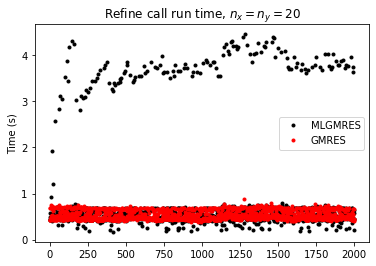

In [10]:
pp.plot(run_timeP2_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r',label='GMRES')
pp.title('Refine call run time, $n_x=n_y=20$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime1.png')

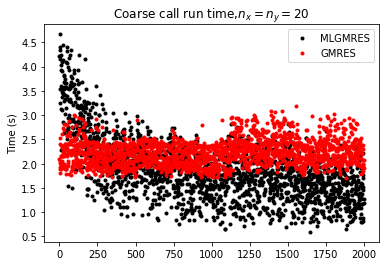

In [11]:
pp.plot(run_timeP1_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r',label='GMRES')
pp.title('Coarse call run time,$n_x=n_y=20$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime2.png')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


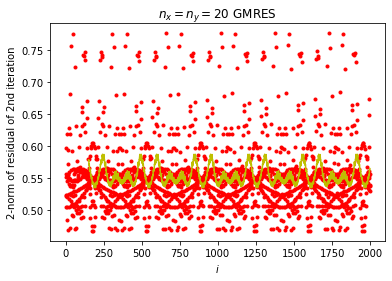

In [12]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[150:-1],AVG[150:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=20$ GMRES')
pp.savefig('GMRES.png')

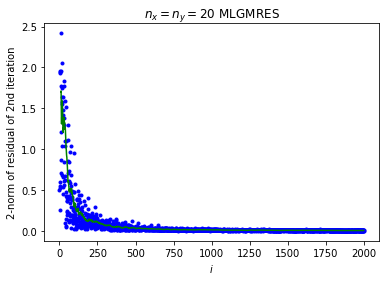

In [13]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=20$ MLGMRES')
pp.savefig('MLGMRES.png')

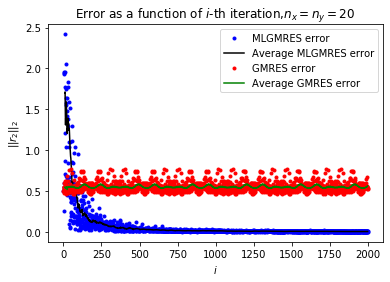

In [14]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration,$n_x=n_y=20$ ')
pp.legend(loc='best')
pp.savefig('Compare.png')

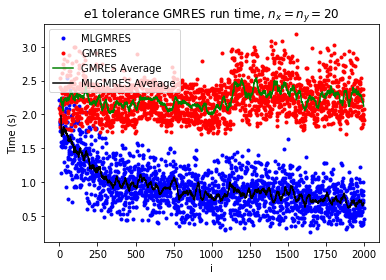

In [15]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n_x=n_y=20$')
pp.legend(loc='best')
pp.savefig('Runtime1.png')

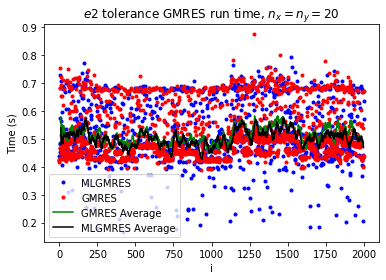

In [16]:
GmresRunTimeOriginal2_AVG=np.zeros((n_steps,1))
ML_GMRES_Time2_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal2_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal2[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time2_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list2[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list2,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal2_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time2_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e2$ tolerance GMRES run time, $n_x=n_y=20$')
pp.legend(loc='best')
pp.savefig('Runtime2.png')

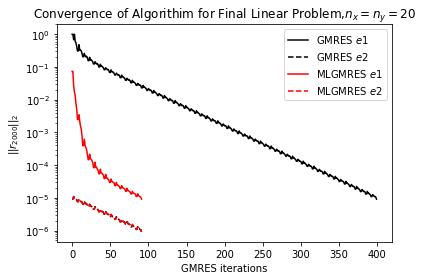

In [17]:
ML_Err=resid(A, Out, b/b_norm)
ML_Err2=resid(A, Out2, b/b_norm)



NonML_Err=resid(A, NonML_Out1, b/b_norm)
NonML_Err2=resid(A, NonML_Out2, b/b_norm)

pp.semilogy(NonML_Err,'k',label='GMRES $e1$')
pp.semilogy(NonML_Err2,'--k',label='GMRES $e2$')
pp.semilogy(ML_Err,'r',label='MLGMRES $e1$')
pp.semilogy(ML_Err2,'--r',label='MLGMRES $e2$')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r_{2000}||_2$')
pp.title('Convergence of Algorithim for Final Linear Problem,$n_x=n_y=20$')
pp.savefig('Error.png')